In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
from scipy.stats import kstest,ttest_ind,fisher_exact
from scipy.stats.contingency import odds_ratio
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce
from scipy.stats import kstest,ttest_ind

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
cohort_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

phenotype_df = pd.read_csv(phenotype_file)


cohort_df = pd.concat([pd.read_csv(cf) for cf in cohort_files])
all_combo_samples = set("|".join(cohort_df.combo_samples.values).split("|"))



In [3]:
categorical_cols = ["genetic_sex"]
numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
scaled_numerical_cols = []#["bmi_prs"]

In [4]:
def get_scaled_bmi(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    # define encoders
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    # save the residuals for bmi
    df['bmi_residuals'] = y - model.predict(X)
    return df

In [5]:
phenotype_df = get_scaled_bmi(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)

In [6]:
phenotype_df["bmi_res_decile"] = pd.qcut(phenotype_df.bmi_residuals, q=10)
phenotype_df["bmi_res_decile_num"] = pd.qcut(phenotype_df.bmi_residuals, q=10, labels=False)
phenotype_combo_samples_df = phenotype_df.loc[phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]
phenotype_other_samples_df = phenotype_df.loc[~phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]

phenotype_other_samples_df["description"] = "Non Combo"
phenotype_combo_samples_df["description"] = "Combo"
phenotype_samples_df = pd.concat((phenotype_combo_samples_df, phenotype_other_samples_df))

/tmp/ipykernel_70858/484366616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_other_samples_df["description"] = "Non Combo"
/tmp/ipykernel_70858/484366616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_combo_samples_df["description"] = "Combo"


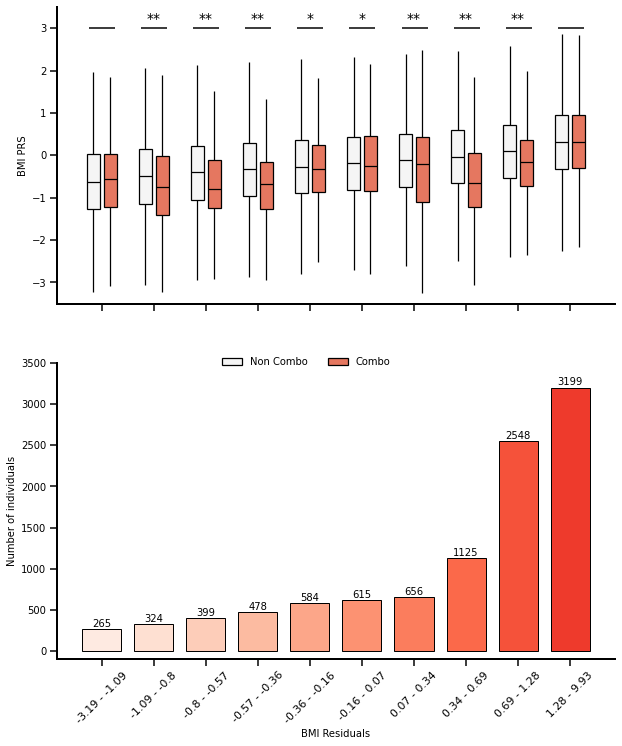

In [7]:
def create_decile_rank_plot(phenotype_samples_df):
    fig,ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True, height_ratios=(4, 4))
    ## BMI prs box plots
    sns_ax = sns.boxplot(
        phenotype_samples_df, x="bmi_res_decile", y="bmi_prs", hue="description", hue_order=["Non Combo", "Combo"],
        width=0.65, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'},
        medianprops={'color':'k'},
        linecolor='k',
        palette= ["whitesmoke", sns.color_palette("Reds", 15).as_hex()[7]],
        legend=True, gap=0.25, ax=ax[0])
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].spines[['right', 'top']].set_visible(False)
    ax[0].hlines([3 for i in range(10)], [(i-0.25+i*0.001953125) for i in range(0, 10)], [(i+0.25+i*0.001953125) for i in range(0,10)], color="k")
    for i, (psdi, psd) in enumerate(phenotype_samples_df.groupby("bmi_res_decile", observed=False)):
        ttest_res = ttest_ind(psd.loc[psd.description=="Combo", "bmi_prs"], psd.loc[psd.description=="Non Combo", "bmi_prs"], alternative="less")
        ttest_pval = ttest_res.pvalue
        if ttest_pval<0.05:
            pval_text = "*"
            if ttest_pval<0.001:
                pval_text = "**"
                # pval_text = f"P = {ttest_pval:.1E}"
            ax[0].text(0.+i, 3.05, pval_text, ha="center", va="bottom", fontsize=14)
    h,l = ax[0].get_legend_handles_labels()
    ax[0].legend_.remove()
    fig.legend(h,l, ncol=2, loc=(0.35, 0.5025), frameon=False)
    ax[0].set_ylabel("BMI PRS")
    
    phenotype_combo_samples_decile_df = phenotype_samples_df.loc[phenotype_samples_df.description=="Combo"].groupby("bmi_res_decile", observed=True).agg({
        "sample_names": "count",
        "bmi_prs": "median",
        "bmi_residuals": "mean"}
        ).reset_index()
    phenotype_combo_samples_decile_df["decile_rank"] = range(10)
    decile_labels =  [" - ".join([str(round(v.left, 2)),str(round(v.right, 2))]) for v in  phenotype_combo_samples_decile_df.bmi_res_decile.values]

    ## Combo per decile barplot
    ax[1].bar(phenotype_combo_samples_decile_df.decile_rank, phenotype_combo_samples_decile_df.sample_names, width=0.75, color=sns.color_palette("Reds", 15).as_hex()[:10], edgecolor="k")
    xticklabels = decile_labels
    ax[1].set_xticks(range(10), xticklabels, rotation=45, ha="center", fontsize=11)
    ax[1].set_xlabel("BMI Residuals")
    ax[1].set_ylabel("Number of individuals")
    # g.bar_label([g.containers[i] for i in range])
    rects = ax[1].patches
    # Make some labels.
    for rect in rects:
        height = rect.get_height()
        ax[1].text(
            rect.get_x() + rect.get_width() / 2, height + 5, f"{height}", ha="center", va="bottom"
        )
    ax[1].set_ylim(-100, 3500)
    ax[1].spines[['right', 'top']].set_visible(False)

    return fig,ax

fig, ax = create_decile_rank_plot(
    phenotype_samples_df
    )

In [8]:
lf_df = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/lifestyle_factors/data/lifestyle_processed/filtered_lifestyle_binarized.csv.gz")

In [9]:
def get_table(top_decile_combo_lf, top_decile_noncombo_lf, field):
    table = [
        [len(top_decile_combo_lf.loc[top_decile_combo_lf[field]==0]), len(top_decile_combo_lf.loc[top_decile_combo_lf[field]==1])],
        [len(top_decile_noncombo_lf.loc[top_decile_noncombo_lf[field]==0]), len(top_decile_noncombo_lf.loc[top_decile_noncombo_lf[field]==1])]
    ]
    df = pd.DataFrame(table, columns=[f"No {field}", f"{field}"], index=["Combo", "Non Combo"])
    return df

def get_rvas_gene(gene_file):
    with open(gene_file, "r") as f:
        genes = set([l.strip() for l in f.readlines()])
    return genes

def prs_interaction_info(phenotype_samples_df, decile):
    top_decile = phenotype_samples_df.loc[phenotype_samples_df.bmi_res_decile_num==decile]
    print(top_decile.loc[top_decile.description=="Non Combo", "bmi_prs"].mean(), top_decile.loc[top_decile.description=="Combo", "bmi_prs"].mean())
    nc_bmi, c_bmi = top_decile.loc[top_decile.description=="Non Combo", "bmi_residuals"], top_decile.loc[top_decile.description=="Combo", "bmi_residuals"]
    print(nc_bmi.mean(), c_bmi.mean())
    print(ttest_ind(nc_bmi, c_bmi, alternative="less"))
    print(kstest(nc_bmi, c_bmi, alternative="greater"))
    top_decile_combo = top_decile.loc[top_decile.description=="Combo"]
    top_decile_noncombo = top_decile.loc[top_decile.description=="Non Combo"]
    table = [
        [len(top_decile_combo.loc[top_decile_combo.bmi_prs<0]), len(top_decile_combo.loc[top_decile_combo.bmi_prs>0])],
        [len(top_decile_noncombo.loc[top_decile_noncombo.bmi_prs<0]), len(top_decile_noncombo.loc[top_decile_noncombo.bmi_prs>0])]
        ]
    df = pd.DataFrame(table, columns=["Negative PRS", "Positive PRS"], index=["Combo", "Non Combo"])
    print(df)
    print(fisher_exact(df))
    top_decile_combo_lf = top_decile_combo.merge(lf_df, left_on="sample_names", right_on="Sample_Name")
    top_decile_noncombo_lf = top_decile_noncombo.merge(lf_df, left_on="sample_names", right_on="Sample_Name")
    lf_fields_check = ["alcohol", "met", "sleep", "smoke", "meat", "sedentary"]
    tables = [get_table(top_decile_combo_lf, top_decile_noncombo_lf, field) for field in lf_fields_check]
    test_res = [fisher_exact(table) for table in tables]
    for ta, tr in zip(tables, test_res):
        print(ta)
        print(tr)
    rvas_studies = [
        "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list",
        # "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/locke/data/locke_genes.txt",
        "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/marenne/data/marenne_genes.txt",
        "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list",
        # "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/gwas/data/gwas_genes.txt",
        # "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/mgi/data/mgi_genes.txt"
    ]
    genotype_df = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/exome_annot/data/processed_burden/all_gene_burden.csv.gz")
    combo_genes = set("|".join(cohort_df.uniq_items.str.replace("Input_", "")).split("|"))
    rvas_genes = reduce(lambda x,y: x.union(y), [get_rvas_gene(gf) for gf in rvas_studies])
    rvas_other_genes = rvas_genes.difference(combo_genes)
    rvas_geno = genotype_df.loc[genotype_df.gene.isin(rvas_other_genes)]
    all_rvas_samples = set(",".join(rvas_geno.samples).split(","))
    combo_samples = set(top_decile_combo.sample_names.astype(str).values)
    noncombo_samples = set(top_decile_noncombo.sample_names.astype(str).values)
    table = [
        [len(combo_samples.difference(all_rvas_samples)), len(combo_samples.intersection(all_rvas_samples)), ],
        [len(noncombo_samples.difference(all_rvas_samples)), len(noncombo_samples.intersection(all_rvas_samples)), ]
    ]
    df = pd.DataFrame(table, columns=["No RVAS", "RVAS"], index=["Combo", "Non Combo"])
    print(df)
    print(fisher_exact(df))
    return


In [10]:
prs_interaction_info(phenotype_samples_df, 9)

0.3105214177355187 0.3233173455737105
2.0984745982940063 2.0939248247220448
TtestResult(statistic=0.3052672958736483, pvalue=0.6199179661063986, df=42762.0)
KstestResult(statistic=0.006326743314792493, pvalue=0.7854701109089998, statistic_location=1.6194182055978195, statistic_sign=1)
           Negative PRS  Positive PRS
Combo              1186          2013
Non Combo         14654         24911
SignificanceResult(statistic=1.0015575028182786, pvalue=0.9696398483292873)
           No alcohol  alcohol
Combo            2840      359
Non Combo       35123     4442
SignificanceResult(statistic=1.000485599473462, pvalue=1.0)
           No met   met
Combo        2473   726
Non Combo   30757  8808
SignificanceResult(statistic=0.9754855240908674, pvalue=0.565975917594516)
           No sleep  sleep
Combo          3114     85
Non Combo     38347   1218
SignificanceResult(statistic=1.1636317895870372, pvalue=0.19911003452579054)
           No smoke  smoke
Combo          2981    218
Non Combo   

           No RVAS  RVAS
Combo         2980   219
Non Combo    37318  2247
SignificanceResult(statistic=0.8193262350167791, pvalue=0.007329441399669257)


In [11]:
prs_interaction_info(phenotype_samples_df, 8)

0.10123257911139595 -0.1769029237340267
0.950325461132869 0.9774498016301661
TtestResult(statistic=-8.020160453148904, pvalue=5.413546687822826e-16, df=42762.0)
KstestResult(statistic=0.08047106847513225, pvalue=3.1453870463496946e-14, statistic_location=0.9141524059665325, statistic_sign=1)
           Negative PRS  Positive PRS
Combo              1494          1054
Non Combo         18258         21958
SignificanceResult(statistic=1.7047062939112443, pvalue=1.7970201885149162e-38)
           No alcohol  alcohol
Combo            2147      401
Non Combo       33664     6552
SignificanceResult(statistic=1.0420674786417985, pvalue=0.47180555419774395)
           No met   met
Combo        2049   499
Non Combo   32982  7234
SignificanceResult(statistic=0.9006227845904653, pvalue=0.04368637561146502)
           No sleep  sleep
Combo          2489     59
Non Combo     39347    869
SignificanceResult(statistic=0.9317105992617618, pvalue=0.5751240246674766)
           No smoke  smoke
Combo     

           No RVAS  RVAS
Combo         2395   153
Non Combo    37894  2322
SignificanceResult(statistic=0.9591926705764376, pvalue=0.6302871147034466)


In [12]:
prs_interaction_info(phenotype_samples_df, 7)

-0.027924640908953864 -0.5578924024533334
0.5051813426218393 0.5292769478174004
TtestResult(statistic=-7.836639784847737, pvalue=2.367036874799176e-15, df=42762.0)
KstestResult(statistic=0.11659678026209397, pvalue=1.0727246227687908e-13, statistic_location=0.5685372429135988, statistic_sign=1)
           Negative PRS  Positive PRS
Combo               833           292
Non Combo         21310         20329
SignificanceResult(statistic=2.7214146358709974, pvalue=5.304065780377557e-54)
           No alcohol  alcohol
Combo             915      210
Non Combo       33957     7682
SignificanceResult(statistic=0.9857046096113151, pvalue=0.8456471522921483)
           No met   met
Combo         939   186
Non Combo   34959  6680
SignificanceResult(statistic=0.9646507567851372, pvalue=0.6508556093762561)
           No sleep  sleep
Combo          1110     15
Non Combo     40832    807
SignificanceResult(statistic=1.4625293887147335, pvalue=0.1847902882924488)
           No smoke  smoke
Combo     

           No RVAS  RVAS
Combo         1057    68
Non Combo    39359  2280
SignificanceResult(statistic=0.900444326209866, pvalue=0.3889163981241611)


In [13]:
prs_interaction_info(phenotype_samples_df, 0)

-0.6220783479279418 -0.5460981839622641
-1.3729039992924825 -1.3725036702043583
TtestResult(statistic=-0.027027330940395625, pvalue=0.48921903058592187, df=42762.0)
KstestResult(statistic=0.05172578977440978, pvalue=0.23599242118954045, statistic_location=-1.1503492935072073, statistic_sign=1)
           Negative PRS  Positive PRS
Combo               194            71
Non Combo         31534         10965
SignificanceResult(statistic=0.950107954124187, pvalue=0.7248291510663787)
           No alcohol  alcohol
Combo             202       63
Non Combo       33053     9446
SignificanceResult(statistic=0.9163215019264395, pvalue=0.5533459179493865)
           No met   met
Combo         220    45
Non Combo   37638  4861
SignificanceResult(statistic=0.631406793370766, pvalue=0.006670663888887117)
           No sleep  sleep
Combo           258      7
Non Combo     41948    551
SignificanceResult(statistic=0.48413001130651556, pvalue=0.09070694440684199)
           No smoke  smoke
Combo       

           No RVAS  RVAS
Combo          248    17
Non Combo    40272  2227
SignificanceResult(statistic=0.8067143424711959, pvalue=0.4045691734510644)


In [14]:
prs_interaction_info(phenotype_samples_df, 1)

-0.4974642239432753 -0.7267212598148148
-0.9331174330298325 -0.9296764002195381
TtestResult(statistic=-0.7359969994171516, pvalue=0.2308682804687595, df=42762.0)
KstestResult(statistic=0.04378498039352574, pvalue=0.2830036153582894, statistic_location=-0.8996014034358528, statistic_sign=1)
           Negative PRS  Positive PRS
Combo               243            81
Non Combo         29759         12681
SignificanceResult(statistic=1.2783695688699217, pvalue=0.05877228819625391)
           No alcohol  alcohol
Combo             266       58
Non Combo       32984     9456
SignificanceResult(statistic=1.314794215795328, pvalue=0.0604582016445329)
           No met   met
Combo         286    38
Non Combo   37570  4870
SignificanceResult(statistic=0.9755964305226734, pvalue=0.8611440568625708)
           No sleep  sleep
Combo           322      2
Non Combo     42004    436
SignificanceResult(statistic=1.671174173888201, pvalue=0.777740209386341)
           No smoke  smoke
Combo           303 

           No RVAS  RVAS
Combo          307    17
Non Combo    40229  2211
SignificanceResult(statistic=0.9925192976094214, pvalue=0.900373797049461)


In [15]:
prs_interaction_info(phenotype_samples_df, 2)

-0.41231355948127935 -0.6698628962656642
-0.6813324429626569 -0.6806282342233391
TtestResult(statistic=-0.21536566922582373, pvalue=0.4147416305323702, df=42762.0)
KstestResult(statistic=0.047022726176943586, pvalue=0.1686946560709479, statistic_location=-0.5829133803512745, statistic_sign=1)
           Negative PRS  Positive PRS
Combo               308            91
Non Combo         28268         14097
SignificanceResult(statistic=1.6878775674587192, pvalue=6.6054853825333625e-06)
           No alcohol  alcohol
Combo             309       90
Non Combo       33210     9155
SignificanceResult(statistic=0.9464669276322393, pvalue=0.6688298543215313)
           No met   met
Combo         357    42
Non Combo   37119  5246
SignificanceResult(statistic=1.2012985263611629, pvalue=0.28505577804622345)
           No sleep  sleep
Combo           393      6
Non Combo     41897    468
SignificanceResult(statistic=0.7316514308900398, pvalue=0.46245005706407233)
           No smoke  smoke
Combo    

           No RVAS  RVAS
Combo          377    22
Non Combo    40102  2263
SignificanceResult(statistic=0.9670238618794801, pvalue=0.8231571922265339)


In [16]:
top_decile = phenotype_samples_df.loc[phenotype_samples_df.bmi_res_decile_num==9]

In [17]:
top_decile

,sample_names,sex,genetic_kinship_to_other_participants,genetic_ethnic_grouping,genetic_sex,year_of_birth,bmi_prs,genetic_pca1,genetic_pca2,genetic_pca3,...,genetic_pca40,menopause,ethnic_background,bmi,age,bmi_scaled,bmi_residuals,bmi_res_decile,bmi_res_decile_num,description
118,1006065,Female,No kinship found,Caucasian,0,1962.0,0.903266,0.235194,0.148114,0.208714,...,1.896730,Not sure - other reason,British,49.98170,-1.434184,4.743124,4.868682,"(1.278, 9.928]",9,Combo
684,1040061,Male,At least one relative identified,Caucasian,1,1944.0,2.283580,-0.633168,-0.277327,-0.048325,...,1.527300,NaN,British,35.19105,1.239898,1.635221,1.505623,"(1.278, 9.928]",9,Combo
802,1047964,Female,At least one relative identified,Caucasian,0,1958.0,1.460210,-0.042128,0.465940,-0.266588,...,1.563860,Not sure - had a hysterectomy,British,37.03560,-0.812304,2.022809,2.145678,"(1.278, 9.928]",9,Combo
814,1048750,Female,At least one relative identified,Caucasian,0,1957.0,-0.492863,-0.347532,-0.505297,-1.201433,...,2.034660,Not sure - had a hysterectomy,British,38.98740,-0.812304,2.432933,2.523408,"(1.278, 9.928]",9,Combo
917,1054068,Male,No kinship found,Caucasian,1,1965.0,0.436035,-0.214666,-0.208835,-0.338791,...,-0.063946,NaN,British,40.79910,-1.807312,2.813619,2.702593,"(1.278, 9.928]",9,Combo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427606,6023260,Female,No kinship found,Caucasian,0,1966.0,-0.493359,-0.099219,0.150727,0.394600,...,-1.313490,No,British,33.39760,-1.558560,1.258370,1.456297,"(1.278, 9.928]",9,Non Combo
427625,6024363,Male,No kinship found,Caucasian,1,1957.0,1.230610,0.680368,-0.742765,-0.243683,...,2.146890,NaN,British,35.03190,-0.812304,1.601779,1.611131,"(1.278, 9.928]",9,Non Combo
427627,6024446,Female,At least one relative identified,Caucasian,0,1951.0,-0.899800,-0.154616,0.054580,-0.074120,...,3.120970,inconsistent,British,36.34260,0.120515,1.877192,1.871833,"(1.278, 9.928]",9,Non Combo
427628,6024528,Male,No kinship found,Caucasian,1,1963.0,0.920357,-0.032865,0.209625,0.728459,...,-2.934300,NaN,British,39.45210,-1.434184,2.530579,2.495640,"(1.278, 9.928]",9,Non Combo


In [18]:
top_decile["bmi_res_decile"] = pd.qcut(top_decile.bmi_residuals, q=10)
top_decile["bmi_res_decile_num"] = pd.qcut(top_decile.bmi_residuals, q=10, labels=False)

/tmp/ipykernel_70858/3680493043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_decile["bmi_res_decile"] = pd.qcut(top_decile.bmi_residuals, q=10)
/tmp/ipykernel_70858/3680493043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_decile["bmi_res_decile_num"] = pd.qcut(top_decile.bmi_residuals, q=10, labels=False)


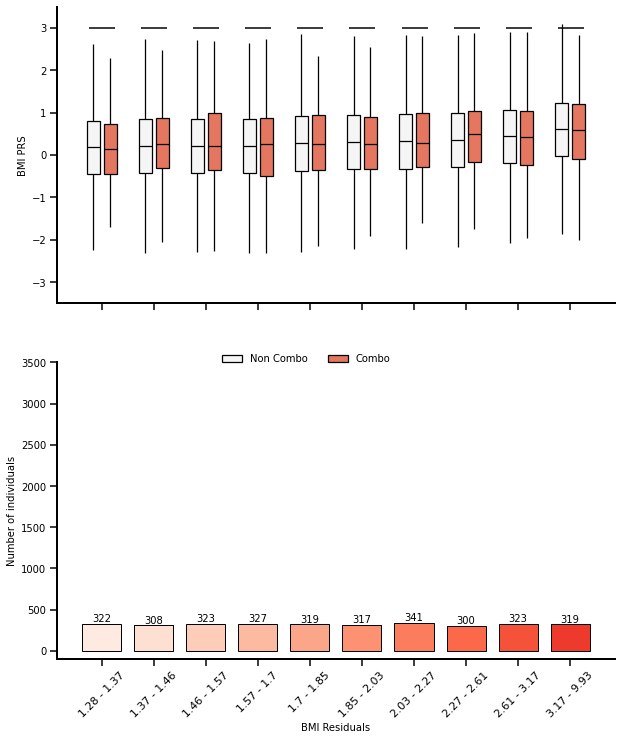

In [19]:
fig, ax = create_decile_rank_plot(
    top_decile
    )